In [22]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [23]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

In [24]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [25]:
gpu = torch.cuda.is_available()

# TODO: set the GPU you want to use
gpu_n = 0

torch.set_default_dtype(torch.float64)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [26]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [27]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **Amortization**



## Step 1: Model

In [28]:
def simplified_chord_model(npcs, data, pobserve=0.5, **kwargs):
    # parameters priors:
    # choose the distribution of chord types
    p_chord = pyro.sample('p_chord', Dirichlet(0.5 * torch.ones(npcs, device=device)))

    # sampling the data:
    nchords = len(data)
    with pyro.plate('data', nchords) as ind:
        # pick a chord type for each chord (now unknown, to be inferred)
        chord_type = pyro.sample('chord_type', Categorical(p_chord))

        # pick a number of notes for each chord based on the chord type
        nnotes = 1 + pyro.sample('n', Poisson(torch.tensor(3., device=device))).int()

        # sample the pitches for each note in the chord
        pitches = pyro.sample('pitches', Dirichlet(0.5 * torch.ones(npcs, device=device)))

    # Return the sampled chord types and pitches
    return {'chord_type': chord_type, 'pitches': pitches}

 Step 2: Amortization Guide for Inference


In [29]:
class AmortizationNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size),
            torch.nn.Softplus()
        )

    def forward(self, x):
        return self.network(x)

In [50]:
input_size = 89
hidden_size = 100
output_size = 62

amortization_net = AmortizationNetwork(input_size, hidden_size, output_size).to(device)

def amortized_guide(npcs, data):
    nchords = len(data['notes'])

    notes = data['notes']
    c = data['c'].unsqueeze(1)
    n = data['n'].unsqueeze(1)

    input_data = torch.cat([notes, c, n], dim=1)

    params = amortization_net(input_data)

    params_p_chord = pyro.param('params_p_chord', torch.ones(npcs, device=device), constraint=constraints.positive)
    pyro.sample('p_chord', Dirichlet(params_p_chord))

    params_pitches = params[:, :npcs]
    params_n = params[:, -1]
    params_chord_type = params[:, npcs:2*npcs]

    with pyro.plate('data', nchords):
        pyro.sample('pitches', Dirichlet(params_pitches))

    with pyro.plate('data_n', nchords):
        pyro.sample('n', Poisson(params_n))

    with pyro.plate('data_chord_type', nchords):
        pyro.sample('chord_type', Categorical(logits=params_chord_type))


## Step 3: Data and Conditioning
**Data Format**


In [31]:
def simplified_chord_tensor(notes):
    """Takes a list of notes as pitch classes and returns a vector of counts."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["notes"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    # Subtracting 1 as the original code suggests notes include a rest, or similar, which is not a note
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [32]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': list(grp.fifth)}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [33]:
def get_init_params(df, npcs):
    init = dict()
    # The prior for the distribution of chords can be estimated from the label frequencies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size(), device=device) + 0.5

    # For the pitches, since we're not distinguishing between chordtones and ornaments,
    # we accumulate all counts into a single distribution.
    pitch_counts = torch.zeros(npcs, device=device) + 0.5
    for fifth, grp in df.groupby('fifth'):
        pitch_counts[utils.fifth_to_index(fifth)] += grp.fifth.count()
    init['pitches'] = pitch_counts

    # Other initial parameters related to the counts of chords and notes will remain the same.
    chord_sizes = df.groupby('chordid').size() - 1
    init['sum_chords'] = torch.tensor(sum(chord_sizes) + 3., device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes) + 1., device=device)

    return init

After inferring the parameters we save them for easier inspection and reuse.



In [34]:
def save_params(params, chordtypes, name):
    torch.save(params, path.join("results", name+'.pt'))
    with open(path.join("results", name+'.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key,val in params.items()},
                   'chordtypes': chordtypes},
                  f)

## Step 4: Inference

In [43]:
def infer_amortized_posteriors(npcs, data, chordtypes, nsteps=5000, lr=0.01, plot_loss=True, save_as=None):

    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    # amortization_net = AmortizationNetwork(input_size, hidden_size, output_size).to(device)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=amortized_guide,
                         optim=pyro.optim.Adam({"lr": lr}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []

    # optimization
    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, data)
        losses.append(loss)

        # print the intermediate results
        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save amortization parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, chordtypes, save_as)

    return params

## Step 5: Plotting

In [36]:
# histories


In [37]:
# posterior


# 2. Experiment

In [38]:
# DCML Corpus
# The DCML corpus is a collection of classical pieces with elaborate harmonic annotations.

# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


In [51]:
dcml_obs

{'notes': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'c': tensor([0, 0, 0,  ..., 8, 0, 0]),
 'n': tensor([19.,  3., 19.,  ...,  7.,  7., 77.])}

  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'data_chord_type', 'data_n'}
  warnings.warn(
  0%|          | 1/350 [00:06<35:00,  6.02s/it]

Step 0 : loss = 7599745.463066413


/usr/local/lib/python3.10/dist-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'data_chord_type', 'data_n'}
  warnings.warn(
 29%|██▉       | 101/350 [05:40<13:41,  3.30s/it]

Step 100 : loss = 7600646.4553404


 57%|█████▋    | 201/350 [11:11<07:41,  3.10s/it]

Step 200 : loss = 7598747.597465698


 86%|████████▌ | 301/350 [16:38<02:48,  3.44s/it]

Step 300 : loss = 7607495.11096221


100%|██████████| 350/350 [19:18<00:00,  3.31s/it]


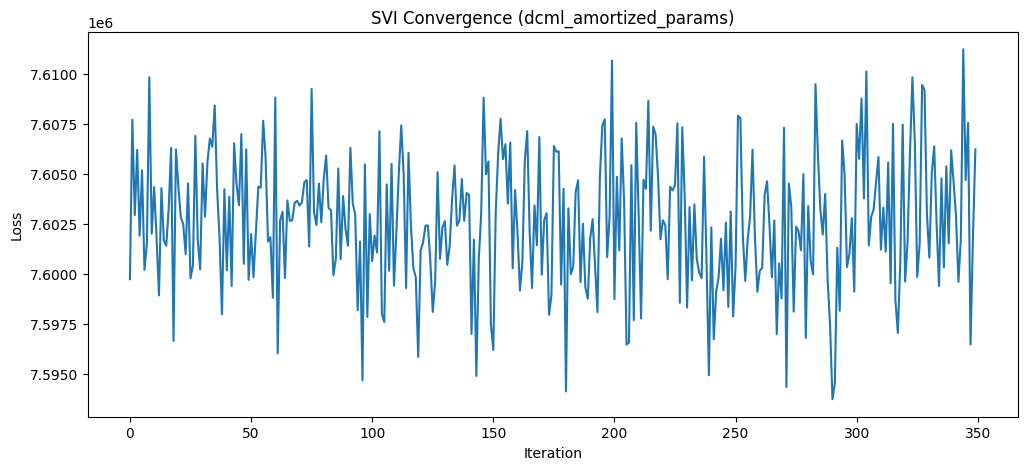

In [52]:
dcml_params = infer_amortized_posteriors(npcs, dcml_obs, dcml_chordtypes,
                                         nsteps=350, lr=0.01, plot_loss=True,
                                         save_as="dcml_amortized_params")